In [2]:
! pip install kagglehub


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
sahilwagh_gold_stock_prices_path = kagglehub.dataset_download('sahilwagh/gold-stock-prices')

print('Data source import complete.')


c:\Users\Alumno_AI\carlos\practicas\recurrentes\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 92.5k/92.5k [00:00<00:00, 907kB/s]

Extracting files...
Data source import complete.


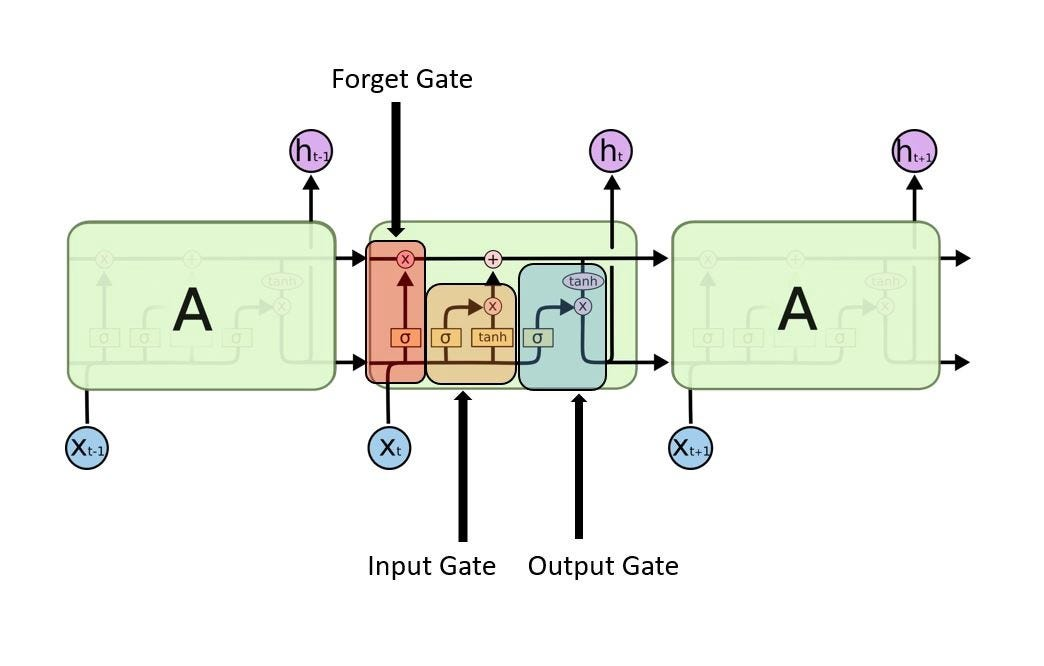


# Predicting the Price of Gold with an LSTM RNN
In this notebook I am using my new knowledge in LSTM RNNs to creat a model able to predict the price of gold. (This notebook is only for educational purposes)

In [1]:
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional

In [2]:
EPOCHS = 50
BATCH_SIZE = 32
TIMESTEP = 60

DATA_PATH = "/kaggle/input/gold-stock-prices/goldstock.csv"

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np

# Descargar datos históricos desde Yahoo Finance
oro = yf.download("GC=F", start="2010-01-01")
dxy = yf.download("DX-Y.NYB", start="2010-01-01")
bonos = yf.download("^TNX", start="2010-01-01")
tip = yf.download("TIP", start="2010-01-01")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
# Unión de datasets
df = pd.concat([oro['Close'], dxy['Close'], bonos['Close'], tip['Close']], axis=1).dropna()
df.columns = ['Oro', 'DXY', 'Bonos', 'TIP']

# Características derivadas
df['Ratio_Oro_DXY'] = df['Oro'] / df['DXY']
df['Inflacion_implicita'] = df['TIP'].pct_change()
df['Tasa_real'] = df['Bonos'] - df['Inflacion_implicita']
df['SMA200'] = df['Oro'].rolling(window=200).mean()
df['Bollinger_up'] = df['Oro'].rolling(window=20).mean() + 2*df['Oro'].rolling(window=20).std()
df['Bollinger_down'] = df['Oro'].rolling(window=20).mean() - 2*df['Oro'].rolling(window=20).std()
df = df.dropna()

# Nuevo objetivo: retorno logarítmico como target
df['retorno_log'] = np.log(df['Oro'] / df['Oro'].shift(1))
df = df.dropna()

In [5]:
features = df.drop(columns=['retorno_log'])
target = df['retorno_log']

In [6]:
df.head()

,Oro,DXY,Bonos,TIP,Ratio_Oro_DXY,Inflacion_implicita,Tasa_real,SMA200,Bollinger_up,Bollinger_down,retorno_log
Date,,,,,,,,,,,
2010-10-20,1343.300049,77.169998,2.470,78.069298,17.407025,-0.000268,2.470268,1190.358999,1386.895931,1273.864054,0.006123
2010-10-21,1324.699951,77.419998,2.531,78.069298,17.110566,0.000000,2.531000,1191.391999,1385.475709,1278.734277,-0.013943
2010-10-22,1324.400024,77.470001,2.563,78.090256,17.095650,0.000268,2.562732,1192.334499,1384.112541,1283.107442,-0.000226
2010-10-25,1338.300049,77.099998,2.554,78.327675,17.357978,0.003040,2.550960,1193.360499,1383.037908,1288.412080,0.010441
2010-10-26,1338.000000,77.709999,2.636,77.901649,17.217861,-0.005439,2.641439,1194.359500,1381.390740,1294.189252,-0.000224


In [7]:
import kagglehub
import pandas as pd
import os

# Descargar la versión específica del dataset
path = kagglehub.dataset_download("sahilwagh/gold-stock-prices/versions/1")

# Mostrar el path completo
print("📁 Ruta del dataset descargado:", path)

# Verifica qué archivos contiene la carpeta
print("📄 Archivos disponibles:", os.listdir(path))

# Leer el CSV correcto (ajusta el nombre si es distinto)
csv_path = os.path.join(path, "goldstock.csv")  # o el nombre exacto del archivo que imprima os.listdir

df = pd.read_csv(csv_path)
print(df.head())


📁 Ruta del dataset descargado: C:\Users\Alumno_AI\.cache\kagglehub\datasets\sahilwagh\gold-stock-prices\versions\1
📄 Archivos disponibles: ['goldstock.csv']
   Unnamed: 0        Date   Close    Volume    Open    High     Low
0           0  2024-01-19  2029.3  166078.0  2027.4  2041.9  2022.2
1           1  2024-01-18  2021.6  167013.0  2009.1  2025.6  2007.7
2           2  2024-01-17  2006.5  245194.0  2031.7  2036.1  2004.6
3           3  2024-01-16  2030.2  277995.0  2053.4  2062.8  2027.6
4           4  2024-01-12  2051.6  250946.0  2033.2  2067.3  2033.1


c:\Users\Alumno_AI\carlos\practicas\recurrentes\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Helper Methods
Below I created a method that will fill in missing Dates with Open prices using the Close price from the previous active business day. These rows could be missing because the market is not open on holidays or weekends. By filling in these missing values we give ourselves more data for our model to train on

In [8]:
"""
  This function takes a dataframe and populates the missing dates in the
  dataframe with the open price set to the close price of the previous day.

  @param df: dataframe
  @return: fully populated dataframe
"""
def populate_missing_date_values(df):
  start_date = df['Date'][0].date()

  # store the dates as a Series
  dates = df['Date']

  dataset = []
  num_days_in_future = 1

  for index, day in enumerate(dates):
    # extract the date from the current row in the dataframe
    current_df_date = str(day.date())

    # skip the first date
    if (index == 0):
      # add the first date to the dataset
      open_price = df['Open'][index]
      day_step = [current_df_date, open_price]
      dataset.append(day_step)
      continue

    # get the open and close prices
    open_price = df['Open'][index]
    close_price = df['Close'][index - 1]

    # get the date of the next day
    current_date = str(start_date + datetime.timedelta(days = num_days_in_future))

    # check if the current date is the same as the current date in the dataframe
    if (current_date != current_df_date):
      found_next_date = False

      # loop until the next date is found
      while not found_next_date:
        if (current_date == current_df_date):
          found_next_date = True

          # add the open price to the dataset
          day_step = [current_date, open_price]
          dataset.append(day_step)
        else:
          # add the close price to the dataset
          day_step = [current_date, close_price]
          dataset.append(day_step)

          # increment the date
          num_days_in_future += 1
          current_date = str(start_date + datetime.timedelta(days=num_days_in_future))
    else:
      # add the open price to the dataset
      day_step = [current_date, open_price]
      dataset.append(day_step)

    num_days_in_future += 1

  return dataset

### Data Loading and Preprocessing
Here we are loading the data from the goldstock.csv into a Pandas dataframe. From there we will sort the dates in ascending order by date (earliest to latest).


Remove any duplicate rows in the dataframe. There are some here. Populte the missing dates/open prices using our helper function. Finally, store only the Date and Open columns in a dataframe

In [9]:
# Asegurar que la fecha esté como columna
if 'Date' not in df.columns:
    df = df.reset_index()  # convierte el índice en columna si es necesario

# Convertir a datetime y ordenar
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date', ascending=True)

# Eliminar duplicados por fecha
df.drop_duplicates(subset=['Date'], keep='first', inplace=True)

# Resetear índice final limpio
df.reset_index(drop=True, inplace=True)


In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdate

# Graficar precio de apertura
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Oro'], color='gold', label='Precio del Oro')

# Formato del eje X por años
plt.gca().xaxis.set_major_locator(mdate.YearLocator())
plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()

# Etiquetas y estilo
plt.title('📈 Evolución Histórica del Precio del Oro')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


KeyError: 'Oro'

<Figure size 1400x600 with 0 Axes>

We will use all of the data up until the end of 2023 for our training set. Then we'll use the data for 2024 as the test set.

In [29]:
# extract the training data and verify it ends at the end of 2023
train_df = df.head(len(df) - 19)
train_df.tail()

,level_0,index,Date,Oro,DXY,Bonos,TIP,Ratio_Oro_DXY,Inflacion_implicita,Tasa_real,SMA200,Bollinger_up,Bollinger_down,retorno_log
3621,3621,3621,2025-03-19,3035.899902,103.430000,4.256,109.427124,29.352218,0.005111,4.250889,2615.6875,3038.337504,2831.262520,0.000263
3622,3622,3622,2025-03-20,3040.000000,103.849998,4.233,109.526489,29.272990,0.000908,4.232092,2619.2730,3053.549558,2826.050466,0.001350
3623,3623,3623,2025-03-21,3018.199951,104.089996,4.252,109.397316,28.996062,-0.001179,4.253179,2622.6310,3062.840796,2824.819214,-0.007197
3624,3624,3624,2025-03-24,3013.100098,104.260002,4.331,109.119102,28.899866,-0.002543,4.333543,2626.0690,3070.075832,2824.104197,-0.001691
3625,3625,3625,2025-03-25,3023.699951,104.180000,4.307,109.297958,29.023804,0.001639,4.305361,2629.4170,3078.866018,2827.234006,0.003512


In [30]:
# extact the test data and verify it starts at January 1st 2024
test_df = df.tail(19)
test_df.reset_index(drop=True, inplace=True)
test_df.head(19)

,level_0,index,Date,Oro,DXY,Bonos,TIP,Ratio_Oro_DXY,Inflacion_implicita,Tasa_real,SMA200,Bollinger_up,Bollinger_down,retorno_log
0,3626,3626,2025-03-26,3020.899902,104.550003,4.338,109.158852,28.894307,-0.001273,4.339273,2632.669999,3086.349237,2830.160773,-0.000926
1,3627,3627,2025-03-27,3060.199951,104.070000,4.369,109.387375,29.405208,0.002093,4.366906,2636.444999,3097.796840,2836.413170,0.012925
2,3628,3628,2025-03-28,3086.500000,104.040001,4.255,109.943810,29.666474,0.005087,4.249913,2640.338999,3105.488851,2853.691154,0.008558
3,3629,3629,2025-03-31,3122.800049,104.209999,4.246,110.380997,29.966415,0.003976,4.242023,2644.415499,3125.072531,2857.367484,0.011692
4,3630,3630,2025-04-01,3118.899902,104.260002,4.156,110.449997,29.914635,0.000625,4.155375,2648.329999,3141.273408,2862.096587,-0.001250
5,3631,3631,2025-04-02,3139.899902,103.809998,4.196,110.279999,30.246604,-0.001539,4.197539,2652.528499,3159.218307,2866.611674,0.006711
6,3632,3632,2025-04-03,3097.000000,102.070000,4.055,110.970001,30.341922,0.006257,4.048743,2656.356499,3165.453670,2878.416301,-0.013757
7,3633,3633,2025-04-04,3012.000000,103.019997,3.985,110.599998,29.237042,-0.003334,3.988334,2659.854500,3159.978980,2894.620995,-0.027830
8,3634,3634,2025-04-07,2951.300049,103.260002,4.155,109.269997,28.581251,-0.012025,4.167026,2662.959000,3152.259021,2908.370960,-0.020359
9,3635,3635,2025-04-08,2968.399902,102.959999,4.262,109.000000,28.830613,-0.002471,4.264471,2666.032000,3145.973077,2920.206903,0.005777


### Process the Training Data
Extract the Open values into a NumPy array and then scale those values to between 0 and 1. Then create time step batches of the training dataset and training label set.  

In [31]:
# extract the Open values into a numpy array
X_train = train_df.iloc[:, 1:2].values

In [34]:
sc = MinMaxScaler(feature_range=(0, 1))

# fit the scaler only on X_train
sc.fit(X_train)

# scale X_train values to between 0 and 1
X_train_scaled = sc.transform(X_train)

In [36]:
TIMESTEP = 60  # o cualquier otro valor que hayas definido

train_data = []
train_labels = []

# Crear ventanas de datos con 60 timesteps
for i in range(TIMESTEP, len(X_train_scaled)):
    train_data.append(X_train_scaled[i - TIMESTEP:i, 0])  # ventana de entrada
    train_labels.append(X_train_scaled[i, 0])             # etiqueta = siguiente valor

# Convertir a arrays numpy
train_data = np.array(train_data)
train_labels = np.array(train_labels)

# Darle forma 3D (samples, timesteps, features)
train_data = np.reshape(train_data, (train_data.shape[0], train_data.shape[1], 1))


Validating that our training data is in the correct shape we see that we have 3571 observations in our training data, 60 timesteps and 1 vector input '**Open**'

In [37]:
print(f"Training Data Shape: {train_data.shape}")
print(f"Training Labels Shape: {train_labels.shape}")

Training Data Shape: (3566, 60, 1)
Training Labels Shape: (3566,)


In [38]:
print("NaN en train_data:", np.isnan(train_data).sum())
print("NaN en train_labels:", np.isnan(train_labels).sum())


NaN en train_data: 0
NaN en train_labels: 0


### Create, Compile and Fit the LSTM RNN Model

In [39]:
regressor = Sequential()

# ✅ Primera capa LSTM debe devolver secuencias si hay otra LSTM después
regressor.add(Bidirectional(LSTM(units=50, return_sequences=True, input_shape=(train_data.shape[1], 1))))
regressor.add(Dropout(0.1))

regressor.add(Bidirectional(LSTM(units=60, return_sequences=True)))
regressor.add(Dropout(0.1))

regressor.add(Bidirectional(LSTM(units=80, return_sequences=True)))
regressor.add(Dropout(0.2))

# ✅ Última LSTM no devuelve secuencias
regressor.add(Bidirectional(LSTM(units=120)))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))  # salida escalar



c:\Users\Alumno_AI\carlos\practicas\recurrentes\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [40]:

# ⚠️ Corrección aquí también: la función de pérdida debe ser 'mean_squared_error', no 'adam'
regressor.compile(optimizer='adam', loss='mean_squared_error')


In [44]:

# Entrenamiento
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', patience=20)
history = regressor.fit(train_data, train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping])


Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - loss: 0.0357
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - loss: 9.2145e-04
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - loss: 8.9201e-04
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - loss: 7.3234e-04
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - loss: 7.1250e-04
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - loss: 8.1380e-04
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - loss: 6.6810e-04
Epoch 8/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step - loss: 6.6236e-04
Epoch 9/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - loss: 5.8773e-04
Epoch 10/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - loss: 5.3652e-04
Epoch 11/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step - loss: 6.1980e-04
Epoch 12/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - loss: 5.8175e-04
Epoch 13/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - loss: 7.8367e-04
Epoch 14/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/st

### Evaluate Model Predictions on Test Data

In [ ]:
last_60_days_2023 = train_df.iloc[:, 1:2].tail(TIMESTEP)
last_60_days_2023 = pd.concat([last_60_days_2023, test_df.iloc[:, 1:2]])
last_60_days_2023 = sc.transform(last_60_days_2023)

X_test = []
for i in range(TIMESTEP, 79):
  X_test.append(last_60_days_2023[i-TIMESTEP:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

c:\Users\Alumno_AI\carlos\practicas\recurrentes\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [67]:
predicted_value = regressor.predict(X_test)
predicted_value = sc.inverse_transform(predicted_value)
predicted_value

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


array([[3579.5046],
       [3580.4678],
       [3581.431 ],
       [3582.3938],
       [3583.357 ],
       [3584.3203],
       [3585.283 ],
       [3586.2458],
       [3587.2085],
       [3588.1714],
       [3589.1345],
       [3590.097 ],
       [3591.0598],
       [3592.0225],
       [3592.9854],
       [3593.9478],
       [3594.9102],
       [3595.8726],
       [3596.8347]], dtype=float32)

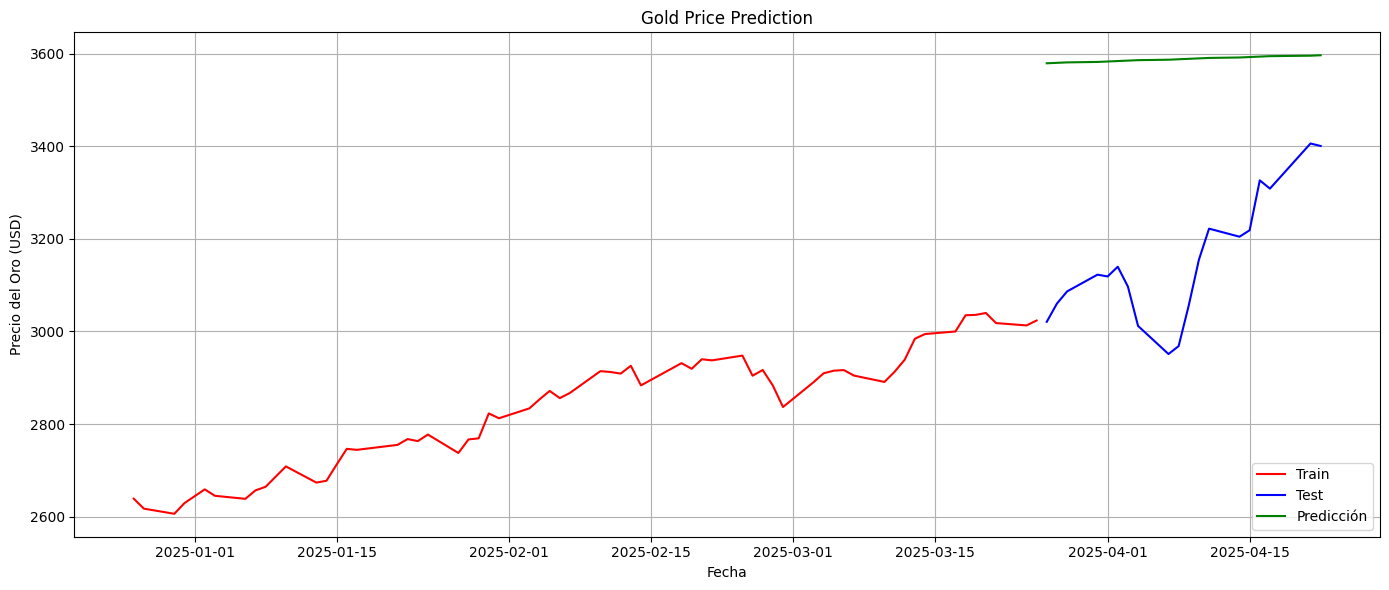

In [76]:
plt.figure(figsize=(14, 6))
plt.plot(train_df.tail(TIMESTEP)['Date'], train_df.tail(TIMESTEP)['Oro'], color='red', label='Train')
plt.plot(test_df['Date'], test_df['Oro'], color='blue', label='Test')
plt.plot(test_df['Date'], predicted_value, color='green', label='Predicción')
plt.title('Gold Price Prediction')
plt.xlabel('Fecha')
plt.ylabel('Precio del Oro (USD)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [77]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Asegúrate de que ambas series tengan igual longitud
real = test_df['Oro'].values[:len(predicted_value)]
pred = predicted_value[:len(real)].flatten()  # Asegura que esté en 1D

# Cálculo de métricas
rmse = np.sqrt(mean_squared_error(real, pred))
mae = mean_absolute_error(real, pred)
mape = np.mean(np.abs((real - pred) / real)) * 100
r2 = r2_score(real, pred)

# Precisión direccional
real_diff = np.sign(np.diff(real))
pred_diff = np.sign(np.diff(pred))
direccion_acertada = (real_diff == pred_diff)
precision_direccional = direccion_acertada.sum() / len(direccion_acertada) * 100

# Mostrar
print("📊 Métricas de rendimiento sobre los datos de test:")
print(f"🔹 RMSE: {rmse:.2f}")
print(f"🔹 MAE: {mae:.2f}")
print(f"🔹 MAPE: {mape:.2f}%")
print(f"🔹 R² Score: {r2:.4f}")
print(f"🔹 Precisión Direccional: {precision_direccional:.2f}%")


📊 Métricas de rendimiento sobre los datos de test:
🔹 RMSE: 455.12
🔹 MAE: 436.72
🔹 MAPE: 14.05%
🔹 R² Score: -10.8732
🔹 Precisión Direccional: 61.11%


C:\Users\Alumno_AI\AppData\Local\Temp\ipykernel_17916\458337011.py:29: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Alumno_AI\AppData\Local\Temp\ipykernel_17916\458337011.py:29: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Alumno_AI\AppData\Local\Temp\ipykernel_17916\458337011.py:29: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Alumno_AI\carlos\practicas\recurrentes\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Alumno_AI\carlos\practicas\recurrentes\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\

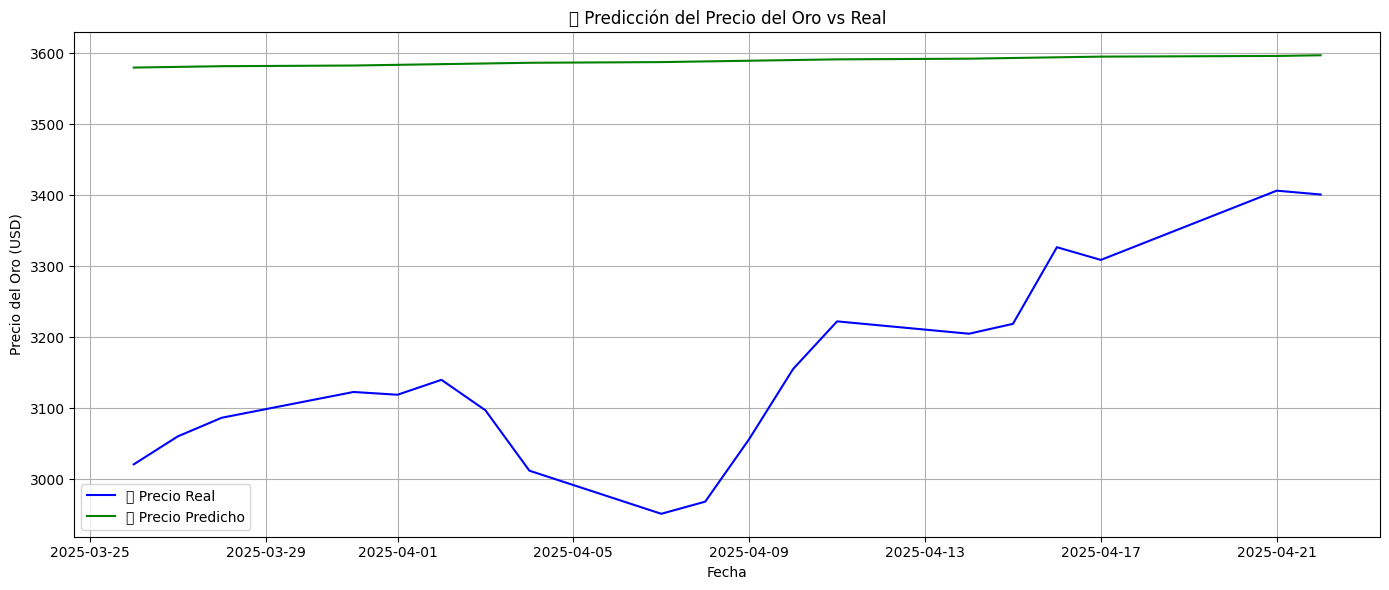

In [78]:
import matplotlib.pyplot as plt
import pandas as pd

# Asegurarse de que las longitudes coincidan
real = test_df['Oro'].values[:len(predicted_value)]
fechas = test_df['Date'].values[:len(predicted_value)]
pred = predicted_value.flatten()

# Crear el DataFrame de comparación
df_comparacion = pd.DataFrame({
    'Fecha': fechas,
    'Precio_Real': real,
    'Precio_Predicho': pred
})

# Establecer la fecha como índice
df_comparacion['Fecha'] = pd.to_datetime(df_comparacion['Fecha'])
df_comparacion = df_comparacion.set_index('Fecha')

# Graficar
plt.figure(figsize=(14, 6))
plt.plot(df_comparacion['Precio_Real'], label='📉 Precio Real', color='blue')
plt.plot(df_comparacion['Precio_Predicho'], label='📈 Precio Predicho', color='green')
plt.title('📊 Predicción del Precio del Oro vs Real')
plt.xlabel('Fecha')
plt.ylabel('Precio del Oro (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\Alumno_AI\AppData\Local\Temp\ipykernel_17916\2365208921.py:24: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Alumno_AI\AppData\Local\Temp\ipykernel_17916\2365208921.py:24: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Alumno_AI\carlos\practicas\recurrentes\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Alumno_AI\carlos\practicas\recurrentes\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


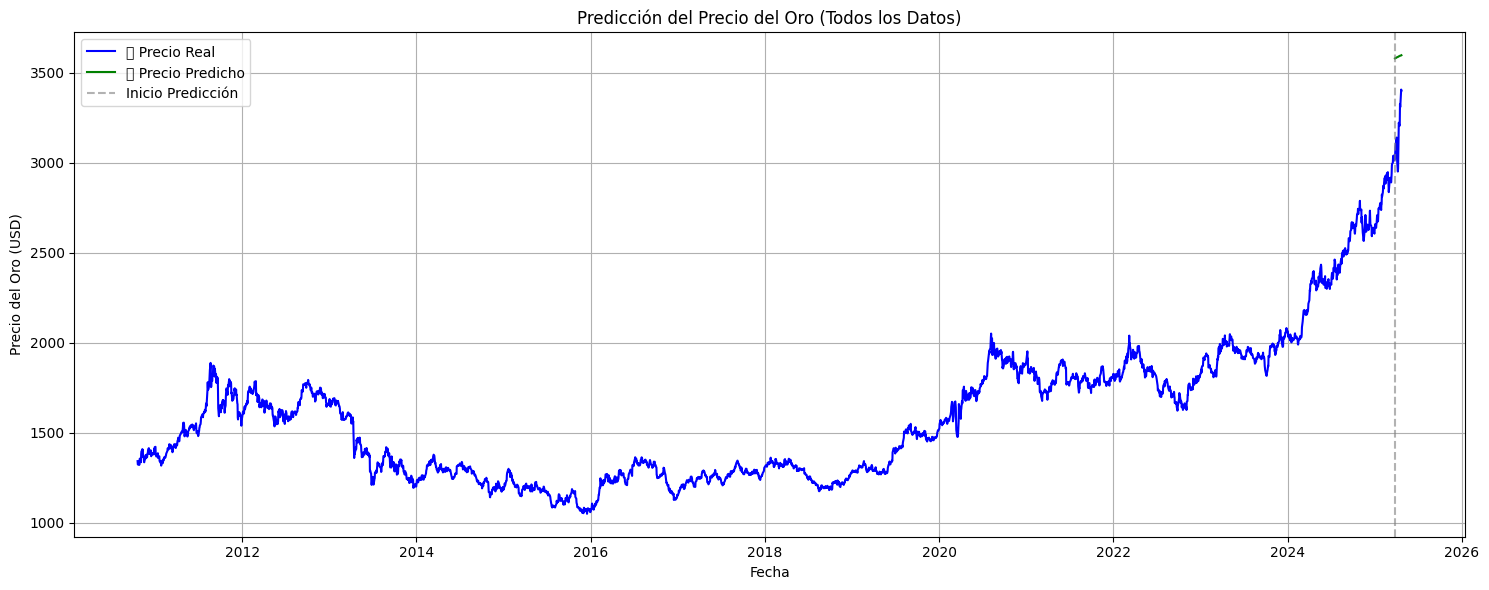

In [71]:
import matplotlib.pyplot as plt
import pandas as pd

# Concatenar entrenamiento y test en un solo DataFrame real
df_real = pd.concat([train_df[['Date', 'Oro']], test_df[['Date', 'Oro']]], axis=0)
df_real['Date'] = pd.to_datetime(df_real['Date'])

# Predicciones solo para test: aseguramos que las fechas coincidan
df_pred = test_df[['Date']].copy()
df_pred['Date'] = pd.to_datetime(df_pred['Date'])
df_pred = df_pred.iloc[:len(predicted_value)].copy()
df_pred['Oro'] = predicted_value.flatten()

# Gráfica
plt.figure(figsize=(15, 6))
plt.plot(df_real['Date'], df_real['Oro'], label='📉 Precio Real', color='blue')
plt.plot(df_pred['Date'], df_pred['Oro'], label='📈 Precio Predicho', color='green')
plt.axvline(df_pred['Date'].iloc[0], color='gray', linestyle='--', alpha=0.6, label='Inicio Predicción')
plt.title('Predicción del Precio del Oro (Todos los Datos)')
plt.xlabel('Fecha')
plt.ylabel('Precio del Oro (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [79]:
# Asumimos que `model` contiene tu modelo entrenado
# Y que ya has escalado los datos como antes

predicted_prices = []
n_days_to_predict = 60  # 3 meses hábiles

for _ in range(n_days_to_predict):
    x_input = np.array(input_sequence[-60:]).reshape(1, 60, 1)
    y_pred = model.predict(x_input, verbose=0)
    
    predicted_prices.append(y_pred[0, 0])
    input_sequence = np.vstack((input_sequence, [[y_pred[0, 0]]]))



NameError: name 'input_sequence' is not defined

### Evaluate the Model Loss

Text(0.5, 0, 'Epoch')

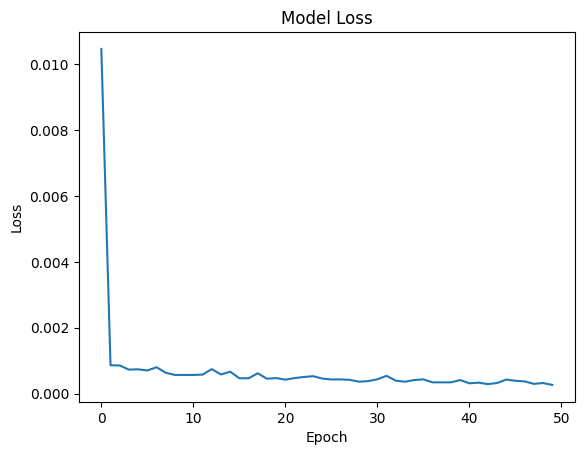

In [72]:
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')